# Cifar10 데이터셋

![](https://wikidocs.net/images/page/266018/%EC%8A%A4%ED%81%AC%EB%A6%B0%EC%83%B7_2024-11-08_004635.png)


**CIFAR-10 데이터셋**은 **머신러닝과 딥러닝에서 이미지 분류(Image Classification)** 문제를 실험하고 연구할 때 가장 널리 사용되는 **표준 벤치마크 데이터셋** 중 하나.

---

### 🧠 기본 정보

| 항목          | 내용                                                               |
| ----------- | ---------------------------------------------------------------- |
| **이름**      | CIFAR-10 (Canadian Institute for Advanced Research 10 classes)   |
| **제공처**     | 캐나다 고등연구소(CIFAR), 토론토대학교의 Alex Krizhevsky, Geoffrey Hinton 등이 제작 |
| **데이터 크기**  | 총 60,000장의 컬러 이미지                                                |
| **이미지 크기**  | 32 × 32 픽셀, RGB(3채널)                                             |
| **클래스 수**   | 10개 (서로 겹치지 않음)                                                  |
| **훈련 데이터**  | 50,000장                                                          |
| **테스트 데이터** | 10,000장                                                          |

---

### 🏷️ 클래스(레이블)

CIFAR-10에는 총 **10개의 클래스**가 있으며, 각각은 서로 다른 물체 범주.

| 클래스 이름     | 설명            |
| ---------- | ------------- |
| airplane   | 비행기           |
| automobile | 자동차 (트럭 제외)   |
| bird       | 새             |
| cat        | 고양이           |
| deer       | 사슴            |
| dog        | 개             |
| frog       | 개구리           |
| horse      | 말             |
| ship       | 배             |
| truck      | 트럭 (자동차와 구분됨) |

---

### 🧩 데이터 구조

* 각 이미지는 32×32 크기의 RGB 이미지 → shape = `(32, 32, 3)`
* 각 클래스당 6,000장씩 균등하게 분포

  * 훈련: 5,000장/클래스
  * 테스트: 1,000장/클래스

---

---

### 🚀 활용 예시

* **CNN(Convolutional Neural Network)** 구조 실험
  → 예: LeNet, AlexNet, VGG, ResNet 등의 구조 실험용
* **데이터 증강(Data Augmentation)** 및 정규화 실험
* **전이학습(Transfer Learning)** 기초 실습
* **GAN, 오토인코더 등 생성 모델** 학습 실험에도 자주 사용

---

### 📊 CIFAR-10의 변형 버전

| 이름             | 특징                              |
| -------------- | ------------------------------- |
| **CIFAR-100**  | 100개의 클래스, 각 600장씩 (보다 세분화된 버전) |
| **CIFAR-10H**  | 사람들의 주관적 확률 분포(불확실성) 포함         |
| **CIFAR-10.1** | 새로운 테스트 세트로 일반화 성능 측정용          |



# import & seed & device

In [1]:
import os
import torch
from torch import nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np


import os
import torch
from torch import nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split

import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

generator = torch.Generator().manual_seed(42)

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"using PyTorch version: {torch.__version__}, Device: {DEVICE}")

using PyTorch version: 2.8.0+cu126, Device: cuda


# 데이터 셋 준비

In [2]:
train_dataset = datasets.CIFAR10(root='CIFAR10_data/', train=True, download=True,
                               transform=transforms.ToTensor())

test_dataset = datasets.CIFAR10(root='CIFAR10_data/', train=False, download=True,
                              transform=transforms.ToTensor())

print()
print(len(train_dataset), len(test_dataset))

100%|██████████| 170M/170M [00:14<00:00, 11.6MB/s]



50000 10000


In [3]:
classes = train_dataset.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [4]:
print(len(train_dataset))

train_dataset_size = int(len(train_dataset) * 0.85)
validation_dataset_size = int(len(train_dataset) * 0.15)

train_dataset, validation_dataset = random_split(train_dataset, [train_dataset_size, validation_dataset_size], generator=generator)

print(len(train_dataset), len(validation_dataset), len(test_dataset))

50000
42500 7500 10000


In [5]:
BATCH_SIZE = 64

train_dataset_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,
                                  shuffle=True, generator=generator)

validation_dataset_loader = DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE,
                                       shuffle=True, generator=generator)

test_dataset_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE,
                                 shuffle=True, generator=generator)

# 첫번째 배치의 데이터 확인

In [6]:
images, labels = next(iter(train_dataset_loader))

print(images.shape, labels.shape)
# torch.Size([64, 3, 32, 32]) torch.Size([64])
#         [batch, channel, height, width]

torch.Size([64, 3, 32, 32]) torch.Size([64])


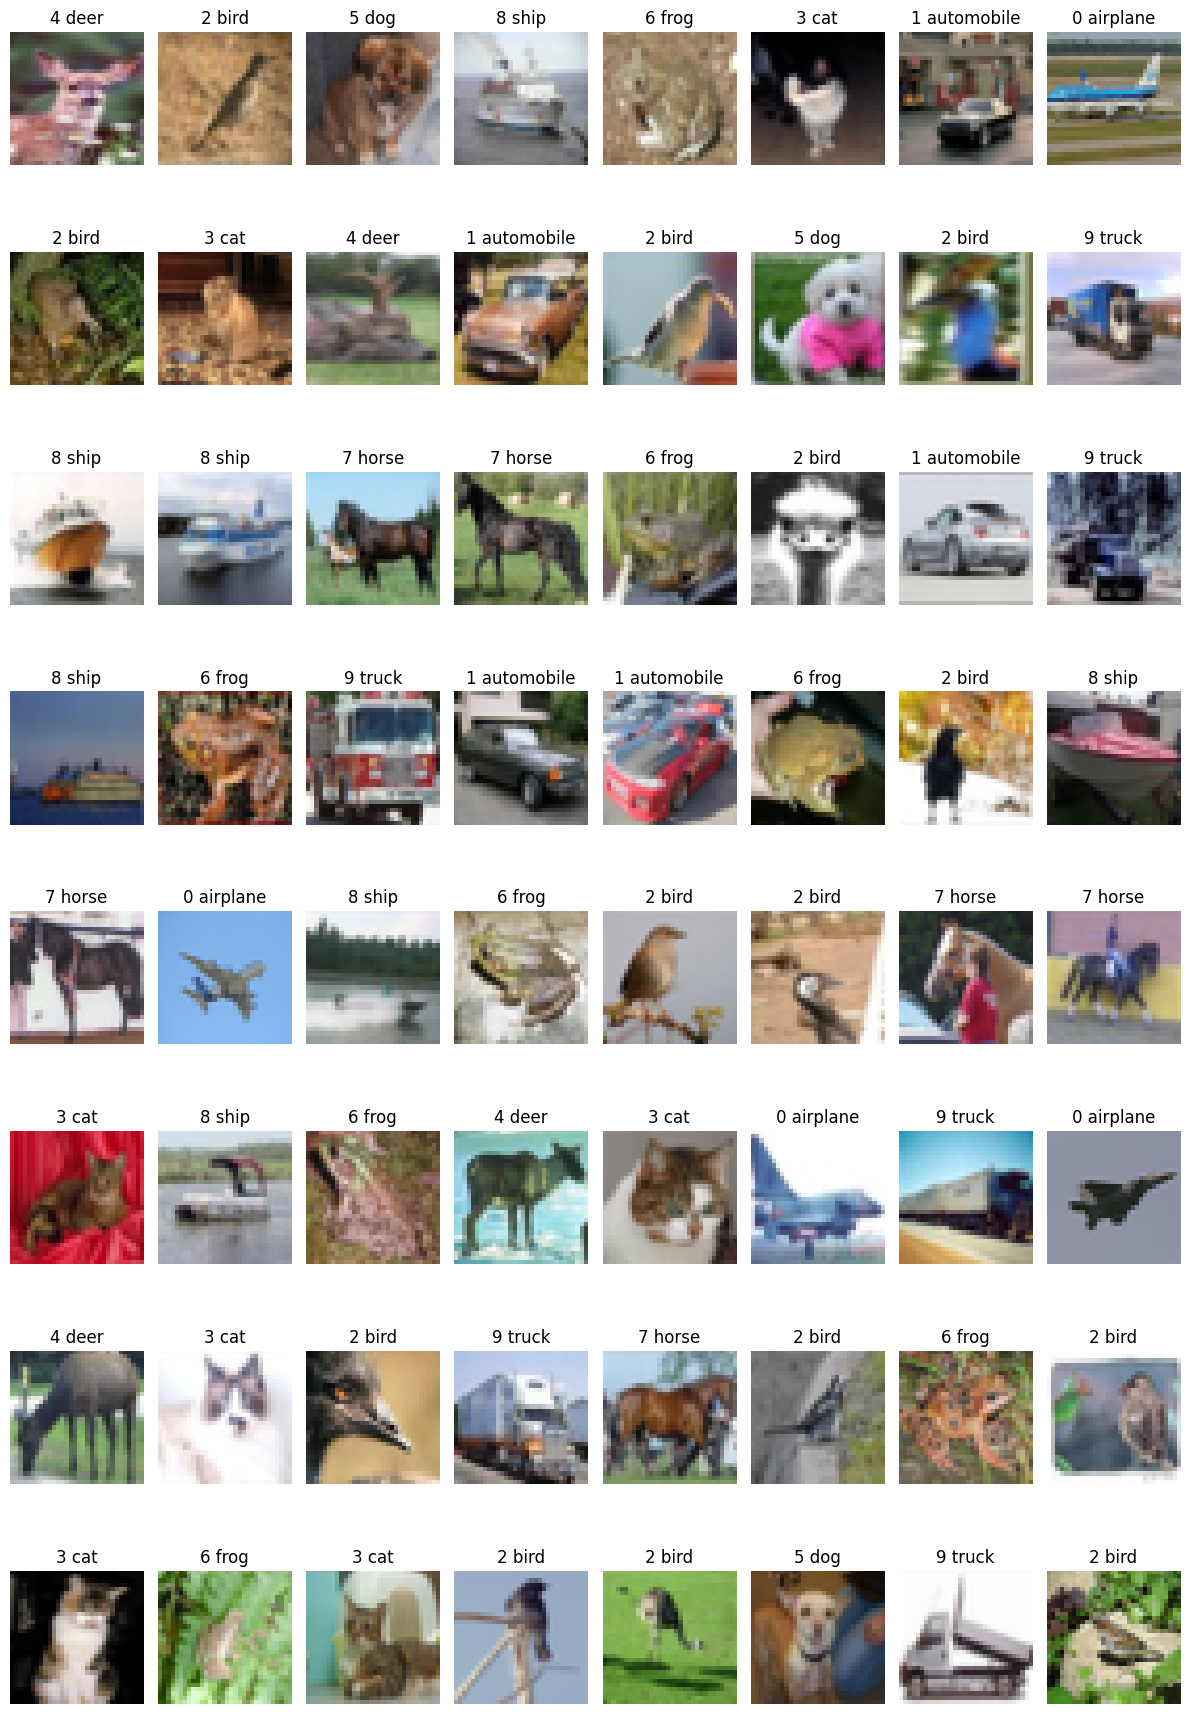

In [7]:
# 8 x 8 로 시각화

fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(12, 18))
axes = axes.flatten()

for i in range(BATCH_SIZE):
  img = images[i].numpy()
  img = np.transpose(img, (1, 2, 0))  # (c, h, w) -> (h, w, c)
  axes[i].imshow(img)
  axes[i].set_title(f'{labels[i].item()} {classes[labels[i].item()]}')
  axes[i].axis('off')

plt.tight_layout()
plt.show()


# 모델 정의 & 생성

In [8]:
class MyCNNModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

    self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(in_features=64 * 8 * 8, out_features=128)
    self.fc2 = nn.Linear(in_features=128, out_features=10)

    self.dropout25 = nn.Dropout(p=0.25)
    self.dropout50 = nn.Dropout(p=0.5)

  def forward(self, data):

      data = self.conv1(data)
      data = torch.relu(data)
      data = self.pooling(data)
      data = self.dropout25(data)

      data = self.conv2(data)
      data = torch.relu(data)
      data = self.pooling(data)
      data = self.dropout25(data)

      data = data.view(-1, 8 * 8 * 64)

      data = self.fc1(data)
      data = torch.relu(data)
      data = self.dropout50(data)

      logits = self.fc2(data)

      return logits


In [9]:
model = MyCNNModel().to(DEVICE)

loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

# train, eval, test 함수 정의

In [10]:
def model_train(dataloader, model, loss_function, optimizer):

  model.train()   # 학습모드. 모델 파라미터 업데이트. Dropout 활성화

  train_loss_sum = 0
  train_correct = 0  # 모델이 맞춘 샘플수 (누적)
  train_total = 0   # epoch 전체에서 처리한 샘플수 (누적)

  total_train_batch = len(dataloader)

  for images, labels in dataloader:

    x_train = images.to(DEVICE)
    y_train = labels.to(DEVICE)

    outputs = model(x_train)

    loss = loss_function(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss_sum += loss.item()

    train_total += y_train.size(0)
    train_correct += (torch.argmax(outputs, 1)==y_train).sum().item()

  train_avg_loss = train_loss_sum / total_train_batch
  train_avg_accuracy = 100 * train_correct / train_total

  return (train_avg_loss, train_avg_accuracy)


In [11]:
def model_evaluate(dataloader, model, loss_function, optimizer):

    model.eval() # 평가 모드(추론 모드, 검증모드) (Dropout 비활성화)

    with torch.no_grad():

        val_loss_sum = 0
        val_correct=0
        val_total = 0

        total_val_batch = len(dataloader)

        for images, labels in dataloader:

            x_val = images.to(DEVICE)
            y_val = labels.to(DEVICE)

            outputs = model(x_val)
            loss = loss_function(outputs, y_val)

            val_loss_sum += loss.item()

            val_total += y_val.size(0)  # label 열 사이즈 같음
            val_correct += ((torch.argmax(outputs, 1)==y_val)).sum().item() # 예측한 값과 일치한 값의 합

        val_avg_loss = val_loss_sum / total_val_batch # 검증 데이터 평균 오차 계산
        val_avg_accuracy = 100*val_correct / val_total # 검증 데이터 평균 정확도 계산

    return (val_avg_loss, val_avg_accuracy)

In [12]:
def model_test(dataloader, model):

    model.eval() # 평가 모드 (Dropout 비활성화)

    with torch.no_grad(): #test set으로 데이터를 다룰 때에는 gradient를 주면 안된다.

        test_loss_sum = 0
        test_correct=0
        test_total = 0

        total_test_batch = len(dataloader)

        for images, labels in dataloader: # images에는 이미지, labels에는 0-9 숫자

            x_test = images.to(DEVICE)
            y_test = labels.to(DEVICE)

            outputs = model(x_test)
            loss = loss_function(outputs, y_test)

            test_loss_sum += loss.item()

            test_total += y_test.size(0)  # label 열 사이즈 같음
            test_correct += ((torch.argmax(outputs, 1)==y_test)).sum().item() # 예측한 값과 일치한 값의 합

        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100*test_correct / test_total

        print('accuracy:', test_avg_accuracy)
        print('loss:', test_avg_loss)

# 학습 함수 정의

In [13]:
def train(model, epochs,
          train_dataset_loader, validation_dataset_loader,
          loss_function, optimizer):
  train_loss_list = []
  train_accuracy_list = []

  val_loss_list = []
  val_accuracy_list = []

  start_time = datetime.now()

  EPOCHS = epochs

  for epoch in range(EPOCHS):

      #==============  model train  ================
      train_avg_loss, train_avg_accuracy = model_train(train_dataset_loader, model, loss_function, optimizer)

      train_loss_list.append(train_avg_loss)
      train_accuracy_list.append(train_avg_accuracy)
      #=============================================

      #============  model evaluation  ==============
      val_avg_loss, val_avg_accuracy = model_evaluate(validation_dataset_loader, model, loss_function, optimizer)

      val_loss_list.append(val_avg_loss)
      val_accuracy_list.append(val_avg_accuracy)
      #============  model evaluation  ==============

      print('epoch:', '%02d' % (epoch + 1),
            'train loss =', '{:.4f}'.format(train_avg_loss), 'train acc =', '{:.4f}'.format(train_avg_accuracy),
            'val loss =', '{:.4f}'.format(val_avg_loss), 'val acc =', '{:.4f}'.format(val_avg_accuracy))

  end_time = datetime.now()

  print('elapsed time => ', end_time-start_time)

  return train_loss_list,train_accuracy_list, val_loss_list, val_accuracy_list

# 훈련

In [14]:
train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list =\
  train(model, 100,
        train_dataset_loader, validation_dataset_loader,
        loss_function, optimizer);


epoch: 01 train loss = 1.7515 train acc = 35.1247 val loss = 1.4450 val acc = 48.3333
epoch: 02 train loss = 1.4605 train acc = 46.8659 val loss = 1.2749 val acc = 54.8667
epoch: 03 train loss = 1.3528 train acc = 51.0776 val loss = 1.1684 val acc = 58.4133
epoch: 04 train loss = 1.2868 train acc = 53.5576 val loss = 1.1493 val acc = 59.7600
epoch: 05 train loss = 1.2382 train acc = 55.7600 val loss = 1.0679 val acc = 62.2267
epoch: 06 train loss = 1.1965 train acc = 57.3412 val loss = 1.0625 val acc = 62.8400
epoch: 07 train loss = 1.1548 train acc = 58.7624 val loss = 1.0140 val acc = 63.9200
epoch: 08 train loss = 1.1240 train acc = 59.8424 val loss = 0.9610 val acc = 65.8267
epoch: 09 train loss = 1.0939 train acc = 61.0094 val loss = 0.9566 val acc = 65.4800
epoch: 10 train loss = 1.0700 train acc = 61.8000 val loss = 0.9424 val acc = 67.2267
epoch: 11 train loss = 1.0543 train acc = 62.6847 val loss = 0.9099 val acc = 67.3600
epoch: 12 train loss = 1.0353 train acc = 63.1929 val 

# 모델의 저장및 로드

In [14]:
base_path = r'/content/drive/MyDrive/KoreaIT (코리아it)/250715 💚자연어처리S4/[자연어처리]/dataset(NLP2507)'

In [15]:
save_path = os.path.join(base_path, 'out', 'CNN_CIFAR10.pth')

In [18]:
# 저장하기
# torch.save(model.state_dict(), save_path)

In [16]:
# 불러오기
model = MyCNNModel().to(DEVICE)
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

# 성능 test

In [17]:
model_test(test_dataset_loader, model)

accuracy: 74.27
loss: 0.7914210584512942


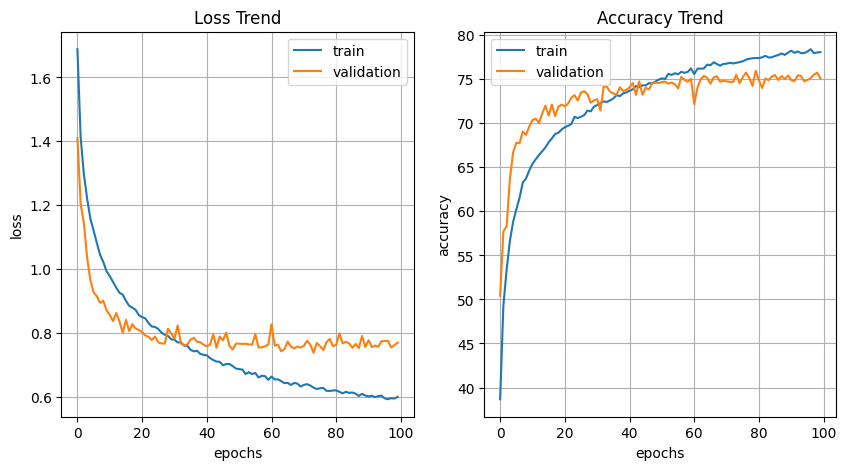

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()
plt.plot(train_accuracy_list, label='train')
plt.plot(val_accuracy_list, label='validation')
plt.legend()

plt.show()

# 🟦 Deep CNN

# transform

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),  # 0 ~ 255 -> 0 ~ 1
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) # 0~1 => -1 ~ +1
])

In [18]:
# ↓채널별 평균/ 표준편차를 구해서 정규화를 해볼수도 있다.

## 채널별 평균및 표준편차 구하기

In [21]:
# train 데이터에서 구하기

train_dataset = datasets.CIFAR10(root='CIFAR10_data/', train=True, download=True,
                                 transform=transforms.ToTensor())

# 전체 데이터를 '하나의 배치'로 묶어서 평균/ 표준편차 계산
train_dataset_loader = DataLoader(train_dataset,
                                  batch_size=len(train_dataset),
                                  shuffle=False)

images, _ = next(iter(train_dataset_loader))  # [batch, C, H, W]

# 채널별 평균과 표준편차 계산 (채널의 dim 은 1)

mean = images.mean(dim=[0, 2, 3])
std = images.std(dim=[0, 2, 3])

print(f'CIFAR10 mean: {mean}')
print(f'CIFAR10 std: {std}')

# CIFAR10 mean: tensor([0.4914, 0.4822, 0.4465])
# CIFAR10 std: tensor([0.2470, 0.2435, 0.2616])

CIFAR10 mean: tensor([0.4914, 0.4822, 0.4465])
CIFAR10 std: tensor([0.2470, 0.2435, 0.2616])


In [22]:
# 위 결과값으로 transform 재정의

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])


# 데이터 준비

In [23]:
train_dataset = datasets.CIFAR10(root='CIFAR10_data/', train=True, download=True,
                               transform=transform)

test_dataset = datasets.CIFAR10(root='CIFAR10_data/', train=False, download=True,
                              transform=transform)

print()
print(len(train_dataset), len(test_dataset))


50000 10000


In [24]:
classes = train_dataset.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [25]:
print(len(train_dataset))

train_dataset_size = int(len(train_dataset) * 0.85)
validation_dataset_size = int(len(train_dataset) * 0.15)

train_dataset, validation_dataset = random_split(train_dataset, [train_dataset_size, validation_dataset_size], generator=generator)

print(len(train_dataset), len(validation_dataset), len(test_dataset))

50000
42500 7500 10000


In [26]:
BATCH_SIZE = 64

train_dataset_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,
                                  shuffle=True, generator=generator)

validation_dataset_loader = DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE,
                                       shuffle=True, generator=generator)

test_dataset_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE,
                                 shuffle=True, generator=generator)

# 모델 정의 & 생성

In [27]:
class MyCNNModel(nn.Module):

  def __init__(self):
    super().__init__()
                      # (in_channel, out_channel, kernel_size, padding)
    self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
    self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
    self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
    self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
    self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
    self.conv7 = nn.Conv2d(128, 256, 3, padding=1)

    self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)

    # 입력 hxw (32x32) -> pooling 5번 -> (1x1)
    self.fc1 = nn.Linear(1 * 1 * 256, 128)
    self.fc2 = nn.Linear(128, 10)

    self.dropout25 = nn.Dropout(p=0.25)
    self.dropout50 = nn.Dropout(p=0.5)

  def forward(self, data):

    # Feature Extraction
    data = self.conv1(data)
    data = torch.relu(data)
    data = self.conv2(data)
    data = torch.relu(data)
    data = self.pooling(data)
    data = self.dropout25(data)

    data = self.conv3(data)
    data = torch.relu(data)
    data = self.conv4(data)
    data = torch.relu(data)
    data = self.pooling(data)
    data = self.dropout25(data)

    data = self.conv5(data)
    data = torch.relu(data)
    data = self.pooling(data)
    data = self.dropout25(data)

    data = self.conv6(data)
    data = torch.relu(data)
    data = self.pooling(data)
    data = self.dropout25(data)

    data = self.conv7(data)
    data = torch.relu(data)
    data = self.pooling(data)
    data = self.dropout25(data)

    # Classification

    data = data.view(-1, 1 * 1 * 256)

    data = self.fc1(data)
    data = torch.relu(data)
    data = self.dropout50(data)

    logits = self.fc2(data)

    return logits

In [28]:
model = MyCNNModel().to(DEVICE)

# 모델 파라미터 확인

In [29]:
model_total = 0

for name, child in model.named_children():
  print('🔶', name)
  layer_total = 0
  for param_name, param in child.named_parameters():
    print('  🟡', f"{param_name:9s}", ':', f"{param.numel():,}개", '←', param.data.shape)
    layer_total += param.numel()

  if layer_total:
    print('  [layer params]:', f"{layer_total:,}개") # parameter 있는 레이어만 출력
    model_total += layer_total

  print()

print(f'[model params]: {model_total:,}개')

🔶 conv1
  🟡 weight    : 864개 ← torch.Size([32, 3, 3, 3])
  🟡 bias      : 32개 ← torch.Size([32])
  [layer params]: 896개

🔶 conv2
  🟡 weight    : 9,216개 ← torch.Size([32, 32, 3, 3])
  🟡 bias      : 32개 ← torch.Size([32])
  [layer params]: 9,248개

🔶 conv3
  🟡 weight    : 18,432개 ← torch.Size([64, 32, 3, 3])
  🟡 bias      : 64개 ← torch.Size([64])
  [layer params]: 18,496개

🔶 conv4
  🟡 weight    : 36,864개 ← torch.Size([64, 64, 3, 3])
  🟡 bias      : 64개 ← torch.Size([64])
  [layer params]: 36,928개

🔶 conv5
  🟡 weight    : 73,728개 ← torch.Size([128, 64, 3, 3])
  🟡 bias      : 128개 ← torch.Size([128])
  [layer params]: 73,856개

🔶 conv6
  🟡 weight    : 147,456개 ← torch.Size([128, 128, 3, 3])
  🟡 bias      : 128개 ← torch.Size([128])
  [layer params]: 147,584개

🔶 conv7
  🟡 weight    : 294,912개 ← torch.Size([256, 128, 3, 3])
  🟡 bias      : 256개 ← torch.Size([256])
  [layer params]: 295,168개

🔶 pooling

🔶 fc1
  🟡 weight    : 32,768개 ← torch.Size([128, 256])
  🟡 bias      : 128개 ← torch.Size([128]

# loss & optimizer

In [30]:
loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

# 훈련

In [31]:
train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list =\
  train(model, 200,
        train_dataset_loader, validation_dataset_loader,
        loss_function, optimizer);

epoch: 01 train loss = 1.9141 train acc = 24.9176 val loss = 1.6579 val acc = 34.0933
epoch: 02 train loss = 1.5131 train acc = 42.6753 val loss = 1.3845 val acc = 48.8133
epoch: 03 train loss = 1.2974 train acc = 53.0659 val loss = 1.1348 val acc = 59.5333
epoch: 04 train loss = 1.1563 train acc = 59.3318 val loss = 1.0934 val acc = 61.4667
epoch: 05 train loss = 1.0742 train acc = 62.1388 val loss = 0.9190 val acc = 67.4533
epoch: 06 train loss = 0.9994 train acc = 65.2776 val loss = 0.9077 val acc = 68.8533
epoch: 07 train loss = 0.9474 train acc = 67.2329 val loss = 0.8546 val acc = 69.6667
epoch: 08 train loss = 0.9146 train acc = 68.4188 val loss = 0.8265 val acc = 70.8933
epoch: 09 train loss = 0.8764 train acc = 69.9153 val loss = 0.8109 val acc = 71.5867
epoch: 10 train loss = 0.8457 train acc = 71.1318 val loss = 0.7966 val acc = 72.2533
epoch: 11 train loss = 0.8301 train acc = 71.6024 val loss = 0.7444 val acc = 73.7067
epoch: 12 train loss = 0.8119 train acc = 72.3812 val 

# 모델의 저장및 로드

In [32]:
base_path = r'/content/drive/MyDrive/KoreaIT (코리아it)/250715 💚자연어처리S4/[자연어처리]/dataset(NLP2507)'

In [33]:
save_path = os.path.join(base_path, 'out', 'CNN_DEEP_CIFAR10.pth')

In [34]:
# 저장하기
torch.save(model.state_dict(), save_path)

In [35]:
# 불러오기
model = MyCNNModel().to(DEVICE)
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

# 성능 test

In [36]:
model_test(test_dataset_loader, model)

accuracy: 82.34
loss: 0.5891082878135572


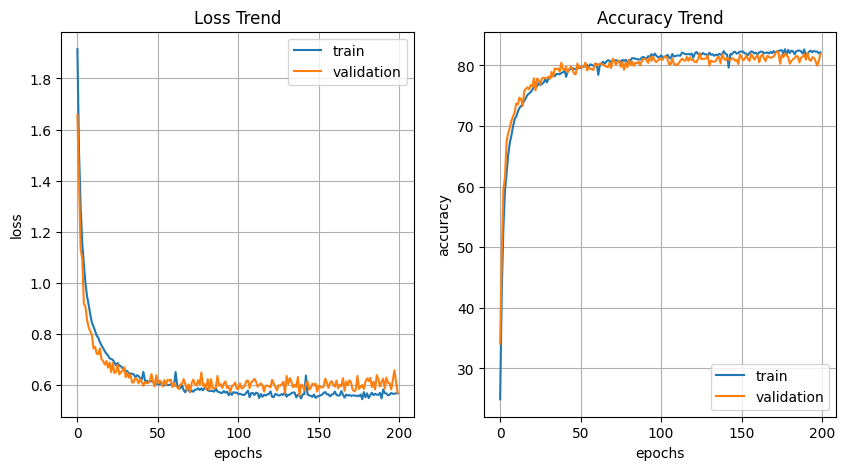

In [37]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()
plt.plot(train_accuracy_list, label='train')
plt.plot(val_accuracy_list, label='validation')
plt.legend()

plt.show()